# Bias in gender recognition of human speech

`Objective:` Estimate the bias of gender classification from speech. 

`Constraints:` Working time <= 12 hours in 3 weeks time span.





For understanding the bias of speech classification, 
(i) gender detection has been chosen among other speech classification problems, such as voice/unvoice classification, number of speakers detection, emotion classification, so on, 
(ii) Mel Frequency Cepstrum Coefficients (MFCCs) of a speech signal have been proved to contain gender information, hence classification model was built on MFCCs of the speech signal. 
(iii) Gaussian mixture models was used to build 2 models for each gender (male/female) describing the distributions of MFCCs, and for new unseen data the gender was classified according to maximum likelihood scores of both models.


# Structure of the notebook: 
  <p><div class="lev1"><a href="#Dataset-structure"><span class="toc-item-num">1&nbsp;&nbsp;</span>Dataset structure</a></div>
 <div class="lev2"><a href="#Mel-frequency-cepstral-coefficients-extraction-from-speech-signal "><span class="toc-item-num">2&nbsp;&nbsp;</span>Mel frequency cepstral coefficients extraction from speech signal</a>

</div><div class="lev3"><a href="#Building-GMMs-on-training-data"><span class="toc-item-num">3&nbsp;&nbsp;</span>Building GMMs on training data</a>

<div class="lev4"><a href="#Classification-of-testing-speech-signals-and-discussion-of-results-in-terms-of-gender-bias"><span class="toc-item-num">4&nbsp;&nbsp;</span>Classification of testing speech signals and discussion of results in terms of gender bias</a>


<div class="lev4"><a href="#References"><span class="toc-item-num">6&nbsp;&nbsp;</span>References</a>   
  
 




In [6]:
# useful starting points
import os
import _pickle
import warnings
import numpy as np
import pandas as pd
from sklearn import mixture
from scipy.io.wavfile import read
import matplotlib.pyplot as plt
from sklearn import preprocessing
import python_speech_features as mfcc

warnings.filterwarnings("ignore")


# Dataset structure

Male and female speech corpus files have been collected from [VoxForge](http://www.repository.voxforge1.org/downloads/SpeechCorpus/Trunk/Audio/Main/16kHz_16bit/) licensed open source  repository in the forms of audiobook recordings of 10 seconds max duration. 


In [2]:
# reading the audiofiles
dest = "data/"
source_male   = "data/male/"
files_male    = [os.path.join(source_male,f) for f in os.listdir(source_male) if f.endswith('.wav')]
source_female   = "data/female/"
files_female    = [os.path.join(source_female,f) for f in os.listdir(source_female) if f.endswith('.wav')]

In [3]:
# splitting audiofiles into train and test samples
np.random.seed(0)
n_male = len(files_male)
index = np.random.permutation(n_male)
train_male = np.asarray(files_male)[index[: int(80*n_male/100)]].tolist()
test_male = np.asarray(files_male)[index[int(80*n_male/100) + 1 :]].tolist()

n_female = len(files_female)
index = np.random.permutation(n_female)
train_female = np.asarray(files_female)[index[: int(80*n_female/100)]].tolist()
test_female = np.asarray(files_female)[index[int(80*n_female/100) + 1 :]].tolist()

print('The number of train female audiofiles is ', len(train_female))
print('The number of train male audiofiles is ', len(train_male))
print('The number of test female audiofiles is ', len(test_female))
print('The number of test male audiofiles is ', len(test_male))

The number of train female audiofiles is  549
The number of train male audiofiles is  546
The number of test female audiofiles is  137
The number of test male audiofiles is  136


# Mel frequency cepstral coefficients extraction from speech signal

One of the key steps in speech recognition and classification is the process of extraction of useful information out of noise and useless information. `Mel frequency cepstral coefficients` are the cepstral domain representation of the signal which characterizes the properties of the vocal tract( cords, tongue, teeth, so on) thus making speech different among individuals and genders as well.  
To obtain the MFCCs, the speech signal has been processed through the following steps (2).

<img src="1.png" >

1. Frame the signal into 25 milliseconds frames to have stationary frequency content of the speech,
2. Apply window function on the overlapping frames of the signal to avoid discontinuities,
3. Apply Short time Fourier transformation on the time domain frames to get the frequency domain representations,

5. Apply the Mel filterbank to the FFT transformation and sum the energy in each filter.
6. Take the logarithm of all filterbank energies.
7. Take the DCT of the log filterbank energies.
8. Keep DCT coefficients 2-13, discard the rest.


[python_speech_features](https://python-speech-features.readthedocs.io/en/latest/) library was used to extract the MFCCs of the signal.


In [4]:
def get_MFCC(fs,audio):
    """
    Obtain the MFCCS of the audio by calling mfcc() function from python_speech_features module 
    INPUT: 
        fs - sampling rate( the number of samples per second)
        audio - array of amplitudes
    OUTPUT:
        features - A numpy array of size (NUMFRAMES by numcep) containing MFCC features.
    """
    features = mfcc.mfcc(audio,fs, winlen = 0.025, winstep = 0.01, numcep=13,appendEnergy = False)
    
    # standardize the features 
    features = preprocessing.scale(features)
    return features

def get_MFCC_of_audiofiles(files):
    """
    Iteratively get the MFCC representation of all the sampling files
    INPUT:
        files - array of file names to read
    OUTPUT:
        OUTPUT - A numpy array of size (numberof files *NUMFRAMES by numcep) containing MFCC features.
    """
    features = np.asarray(());
    for f in files:
        fs,audio = read(f)
        vector   = get_MFCC(fs,audio)
        if features.size == 0:
            features = vector
        else:
            features = np.vstack((features, vector))
    return features

# obtain the features of training male and female data
features_male = get_MFCC_of_audiofiles(train_male)
features_female = get_MFCC_of_audiofiles(train_female)
print("Training Female MFCC samples: ", features_female.shape)
print("Training Male MFCC samples: ", features_male.shape)

Training Female MFCC samples:  (281657, 13)
Training Male MFCC samples:  (296428, 13)


# Building GMMs on training data


Gaussian Mixture models have been used to build two models for both male and female voices. The main purpose of GMM usage is to approximate the distirbution of the frame MFCCs by the linear combination of k components (clusters) of the model which are Normally distributed and have eliptic shape with the advantage of separating the components more robustely than other clustering methods. 


$$
P(X|\pi _k, \mu_k, \Sigma_k) = \sum_{k=1}^{K} \pi _k N (X|\mu_k, \Sigma_k)      
$$

where 

$$
N (X|\mu_k, \Sigma_k) = \frac{1}{\sqrt{2 \pi |\Sigma _k| }} \exp^{(X -\mu _k)^{T} \Sigma_k ^{-1}(X -\mu _k)}
$$
And the aim of the training is to estimate the parameters $ \mu _k, \Sigma _k, \pi _k$ for each class $k$ through maximizing the likelihood of each datapoint being in some cluster.

I have used [sklearn.mixture.GaussianMixture](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) to build models and applied elbow method to decide the optimal number of components for both models.

**To prevent over-fitting  or under-fitting for GMM some analytic criterion such as the 
Akaike information criterion (AIC) or the Bayesian information criterion (BIC) was used to get the optimal number of components for each model.**

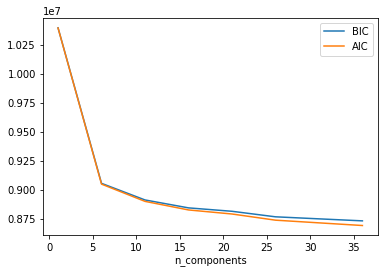

In [7]:
n_components = np.arange(1, 40, 5)
models = [mixture.GaussianMixture(n, covariance_type='full', random_state=0).fit(features_male)
          for n in n_components]

plt.plot(n_components, [m.bic(features_male) for m in models], label='BIC')
plt.plot(n_components, [m.aic(features_male) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

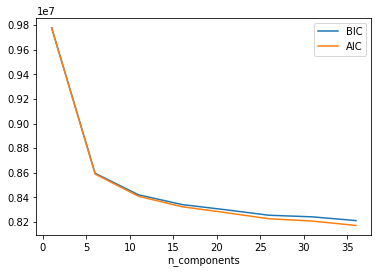

In [8]:
n_components = np.arange(1, 40, 5)
models = [mixture.GaussianMixture(n, covariance_type='full', random_state=0).fit(features_female)
          for n in n_components]

plt.plot(n_components, [m.bic(features_female) for m in models], label='BIC')
plt.plot(n_components, [m.aic(features_female) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

In [29]:
# 26 seems reasonable for the high values oh AIC and BIC
gmm_male = mixture.GaussianMixture(n_components = 26, covariance_type='diag',n_init = 3, random_state=0)
gmm_male.fit(features_male)

gmm_female = mixture.GaussianMixture(n_components = 26, covariance_type='diag',n_init = 3, random_state=0)
gmm_female.fit(features_female)

models = [gmm_male, gmm_female]

picklefile_male = 'male' + '.gmm'
picklefile_female = 'female' + '.gmm'

# Save models
_pickle.dump(gmm_male,open(dest + picklefile_male,'wb'))
_pickle.dump(gmm_female,open(dest + picklefile_female,'wb'))

print('modeling completed for genders:')

def read_models(dest):
    """
    Read the saved models
    
    INPUT: 
        dest- stored directory
    OUTPUT:
    
    """
    # read the models from files
    gmm_files = [os.path.join(dest,fname) for fname in
                  os.listdir(dest) if fname.endswith('.gmm')]
    models    = [_pickle.load(open(fname,'rb')) for fname in gmm_files]

    genders   = [fname.split('/')[-1].split(".gmm")[0] for fname
                  in gmm_files]
    return (models, genders)


modeling completed for genders:


# Classification of speech signals and discussion of results in terms of gender bias

The test data is processed the same way as train data for distribution consistency reasons. 
For each new sample and for each class(m/f) the sum of log likelihood scores is calculated over N samples(N to be the number of frames in my case) and the class was assigned to the class which has the high likelihood.
$$
max _ \theta \sum_{n = 1}^{N}\log\sum_{k=1}^{K} \pi _k N (X|\mu_k, \Sigma_k)
$$



In [25]:
def test(files, models):
    """ 
    A function to read the files, get MFCC information and 
    calculate the Max. Likelihood of the feature for each model
    
    INPUT: 
        files - list of file names to be read
        models - list of models
    OUTPUT: 
        (number_of_males, number_of_females) - representing the number of classified males and females
    """
    number_of_males = 0
    number_of_females = 0
    genders = ['male', 'female']
    for f in files:
        #print(f.split("/")[-1])
        sr, audio  = read(f)
        features   = get_MFCC(sr,audio)
        scores     = None
        log_likelihood = np.zeros(len(models))
        for i in range(len(models)):
            gmm    = models[i]         
            #checking with each model one by one
            scores = np.array(gmm.score(features))
            log_likelihood[i] = scores
        winner = np.argmax(log_likelihood)
        if winner:
            number_of_females = number_of_females + 1 
        else: 
            number_of_males = number_of_males + 1
    return (number_of_males, number_of_females)

In [30]:
mnm, mnf = test(test_male, models)
fnm, fnf = test(test_female, models)

Assuming that the **male is the negative class**, some metrics are calculated to understand the classification performance.

In [31]:
def metrics(mnm,mnf,fnm,fnf):
    acc = (mnm + fnf) / (mnm + mnf + fnm + fnf)
    #The error rate, which is the ratio of instances misclassified
    error_rate = (mnf + fnm )/ (fnf + fnm + mnm + mnf)
    #sensitivity, which is the portion of actual positives predicted as positives
    tpr = fnf/(fnf + fnm )
    #the specificity, which is the portion of actual negatives predicted as negative
    tnr = mnm/(mnm+ mnf)
    return acc, error_rate, tpr, tnr

In [32]:
# male as negative class
acc, error_rate, tpr, tnr = metrics(mnm,mnf,fnm,fnf)
print('With male negative class \n The accuracy is: ', acc,' \n The error rate is ',error_rate,
      'so the model can correctly label a high percentage of the instances',
      '\n The proportion of correctly classified female class is', tpr,
      '\n The proportion of correctly classified male class is', tnr)


With male negative class 
 The accuracy is:  0.9230769230769231  
 The error rate is  0.07692307692307693 so the model can correctly label a high percentage of the instances 
 The proportion of correctly classified female class is 0.8905109489051095 
 The proportion of correctly classified male class is 0.9558823529411765


Male classifier works more accurately than female classifier, so I wouldn't say that the model is biased, because here I have two models with different performances and the fact is that the male model is trained considerably better than the female model. 0.1 proportion of test female speech was classified as male and 0.044 proportion of test male speech to female, and 0.065 difference of the performance result can be because of the 

(i) sample selection (diversity of voices in m/f samples),

(ii) model selection( cross validate over the data to take the best characterizing split samples)

which is left as further work to be done to understand the small drawback of gender bias in classification and improve classification accuracy to some defined metric.


# References 

Literature and material review:


Papers

[1]. [Automatic Identification of Gender from Speech](http://www.cs.columbia.edu/~sarahita/papers/speech_prosody16.pdf),

[2]. [Robust voiced/unvoiced classification using using novel features and Gaussain mixture model](https://pdfs.semanticscholar.org/293e/aa337555a443fe5f33ae33b330225f278765.pdf),



Blogs

(1). [Voice Gender Detection using GMMs : A Python Primer](https://appliedmachinelearning.blog/2017/06/14/voice-gender-detection-using-gmms-a-python-primer/#comments)

(2). [Mel Frequency Cepstral Coefficient (MFCC)](http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/)

### I have completted this work in (12,13) hour time interval, 

`2 hours` literature and existing work review,

`2-3 hours` data collection (more than I scheduled because I had to make the samples as much homogenous as possible, untill I found the voxForge),

`4-5 hours` implementation and running

`1 hour` improving the samples of the data

`2 hours` implementation, running and reporting

Mariam Hakobyan